<h1>Building Knowledge Graphs: Amazon Samsung Review Example</h1>
    <h6> I used Prateek Joshi's tutorial at https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/ to complete this assignment</h6> 

<h2> Initial Setup: Loading the libraries that will be used and identifying the directory and file where we will be working.</h2>

In [1]:
#import the libraries that will be used

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
#determine the path to the directory where we will be working

path = "/Users/roman_Sv/Downloads/"
file = open(path+"article_prime_Reviewer.txt", "r")

<h2> Part 1: Data Preparation </h2> 
    <h3>Step 1: Perform sentence segmentation - split the text file into separate sentences</h3>

In [3]:
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
data = file.read()
split_file = tokenizer.tokenize(data)
split_file

["eviewed in the United States on August 25, 2019\nStyle: Note 10+Size: 256GBColor: Aura White\nSMARTPHONE INTRO\n\nI've been buying the latest and greats smartphones since the early HTC days and have owned just about every significant Samsung smartphone release since then.",
 'Every year I will stray over to other manufacturers to see what the big and small players are up to.',
 'Most, but not all of the time, I find myself right back to my Samsung phone as the daily driver.',
 'Which is usually a Note.',
 "Now that Samsung has released another Note series for an increasingly high price, let's see how it does.",
 "In particular against my Note 9 that it's replacing.",
 'PROS:\n+ Excellent build quality\n+ The high-resolution OLED display somehow looks even better than before\n+ Superfast performance; zero lag\n+ Much improved speakers that you can *feel*\n+ The bezels continue to disappear; nearly all-screen\n+ Core functions, such as phone calls, still work great\n+ Lots of internal 

<h4>Step 1.1: Check that segmentation was done correctly</h4>

<h4> After inspecting the resulting list, it became apparent that after tokenizing the data, some of the sentences were not segmented correctly. For instance, the PROS and CONS paragraphs along with titles of the subsections. Hence, I used a for loop to go through each individual sentence (element of the split file) to check if that element could be split into additional sentences.</h4>

In [4]:
split_new = []
array_length = len(split_file)
for i in range(array_length):   
    split_new.append(split_file[i].splitlines())
split_new

[['eviewed in the United States on August 25, 2019',
  'Style: Note 10+Size: 256GBColor: Aura White',
  'SMARTPHONE INTRO',
  '',
  "I've been buying the latest and greats smartphones since the early HTC days and have owned just about every significant Samsung smartphone release since then."],
 ['Every year I will stray over to other manufacturers to see what the big and small players are up to.'],
 ['Most, but not all of the time, I find myself right back to my Samsung phone as the daily driver.'],
 ['Which is usually a Note.'],
 ["Now that Samsung has released another Note series for an increasingly high price, let's see how it does."],
 ["In particular against my Note 9 that it's replacing."],
 ['PROS:',
  '+ Excellent build quality',
  '+ The high-resolution OLED display somehow looks even better than before',
  '+ Superfast performance; zero lag',
  '+ Much improved speakers that you can *feel*',
  '+ The bezels continue to disappear; nearly all-screen',
  '+ Core functions, such 

<h4> Step 1.2: Load each individual sentence into a separate cell in one column in a CSV file to perform manual inspection that sentences are segmented correctly </h4>

In [5]:
df =  pd.DataFrame(split_file)
df.to_csv(path+'test_exercise1.csv', index=False)

In [6]:
#read in the csv file
candidate_sentences = pd.read_csv(path+"modified.csv")
candidate_sentences.shape

(181, 1)

In [7]:
candidate_sentences['sentence'].sample(5)

35             but it's easy enough to get used to after a few hours.
19                                 + 3 Camera Lenses for any scenario
116              And if it doesn't read your fingerprint right away, 
87                 Anytime there is a bright scene around that area, 
86     it does have a negative impact with the multimedia experience.
Name: sentence, dtype: object

<h2> Part 2: Concepts Extraction using POS tags </h2> 

<h4> We will be parsing the every sentence's dependency tree. The subject/object were extracted along with their modifiers and the punctuation marks between them.</h4>

<h4> Step 1: Check if individual words are assigned to correct POS tags </h4>

In [8]:
doc = nlp(candidate_sentences['sentence'][7])

for tok in doc:
  print(tok.text, " is a ", tok.dep_)

Now  is a  ROOT
that  is a  mark
Samsung  is a  nsubj
has  is a  aux
released  is a  ccomp
another  is a  det
Note  is a  compound
series  is a  dobj
for  is a  prep
an  is a  det
increasingly  is a  advmod
high  is a  amod
price  is a  pobj
,  is a  punct


<h4> Step 2: Extract concepts pair (subject, object) using the grammar of the sentences and accounting for the fact that subjects and objects may span over several words.</h4>

In [9]:
def get_concepts(sent):
  
  concept1 = ""
  concept2 = ""

    #next 2 variables hold i-1_th pos tag and text respectively
  prv_tok_dep = ""    
  prv_tok_text = ""  
    
    #next 2 variables hold the text associated with subject/object
  prefix = ""
  modifier = ""

  
    #loop through tokens, add prefix when we come across subject/object that is a compound word
  for tok in nlp(sent):    
    if tok.dep_ != "punct":    
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
            
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
        
    #if token is a subject, append to concept1
      if tok.dep_.find("subj") == True:
        concept1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      
    
    #if token is an object, append to concept2
      if tok.dep_.find("obj") == True:
        concept2 = modifier +" "+ prefix +" "+ tok.text
          
    # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  

  return [concept1.strip(), concept2.strip()]

In [10]:
#check if the function retrieves the concepts pair correctly
get_concepts(candidate_sentences['sentence'][7])

['Samsung', 'high Note price']

In [11]:
#parse through every sentence to receive all concept pairs

concept_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  concept_pairs.append(get_concepts(i))

100%|██████████| 181/181 [00:01<00:00, 96.44it/s] 


In [12]:
#check what concept pairs we got
concept_pairs

[['', 'United August'],
 ['', '256 GB Color'],
 ['', ''],
 ['I', 'significant Samsung smartphone release'],
 ['big  players', 'other  what'],
 ['myself', 'daily Samsung driver'],
 ['Which', ''],
 ['Samsung', 'high Note price'],
 ['how  it', ''],
 ['9  it', 'particular  Note'],
 ['', ''],
 ['', ''],
 ['high resolution OLED display', ''],
 ['improved  you', 'improved  speakers'],
 ['screen  functions', 'such phone calls'],
 ['Lots', 'internal  storage'],
 ['Generous  that', ''],
 ['', 'heavy phone usage days'],
 ['useful  stylus', ''],
 ['', '3 Camera scenario'],
 ['', 'useful video features'],
 ['', ''],
 ['Hole punch camera', ''],
 ['in fingerprint reader', 'physical  sensor'],
 ['', ''],
 ['Price', ''],
 ['', ''],
 ['more  I', 'Galaxy Note'],
 ['It', 'more  it'],
 ['', 'particular Samsung OEM cases'],
 ['high quality you', 'hand'],
 ['left  side', 'power button'],
 ['bottom', ''],
 ['rest', 'phone'],
 ['I', 'right'],
 ['it', 'few  hours'],
 ['I', 'white  things'],
 ['I', 'it'],
 ['It'

<h2> Part 3: Relationships Extraction using POS tags </h2> 

<h4> The following section is based on the assumption that the main verb of the sentence is the predicate </h4>
<h4> The get_relation() is looking for the ROOT POS tage or the main verb in the sentence. Once we get a ROOT, it checks if a ‘prep’ POS tag/agent word follow it. If so, the prer/agent word is added to the main verb.

In [13]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [14]:
#parse through every sentence to receive all relationships between concepts

relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 181/181 [00:01<00:00, 109.95it/s]


In [15]:
#check what the most common relationships are 

pd.Series(relations).value_counts()[:50]

is               19
are               5
's                5
like              3
has               3
have              3
need              2
continue          2
plug              2
use               2
justify           2
tend              2
mention           2
want              2
found             2
go                2
looks             1
picture           1
can               1
going             1
had more          1
DISPLAY           1
stray             1
suspect much      1
provides          1
comparing         1
CAMERAS           1
display           1
be surprised      1
prefer            1
is reliable       1
work great        1
starts            1
In particular     1
mirror            1
enabled           1
complaints        1
welcome           1
used to           1
battery           1
continues         1
SOFTWARE          1
opted for         1
INTRO             1
perform other     1
in                1
further           1
Watching high     1
Lenses for        1
distracting       1


In [16]:
source = [i[0] for i in concept_pairs]

# extract object
target = [i[1] for i in concept_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

<h2> Part 4: Building the Knowledge Graph </h2> 

<h4> We will be building a directed graph (nodes + directed edges) based off the obtained relationships pairs.</h4>


In [17]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

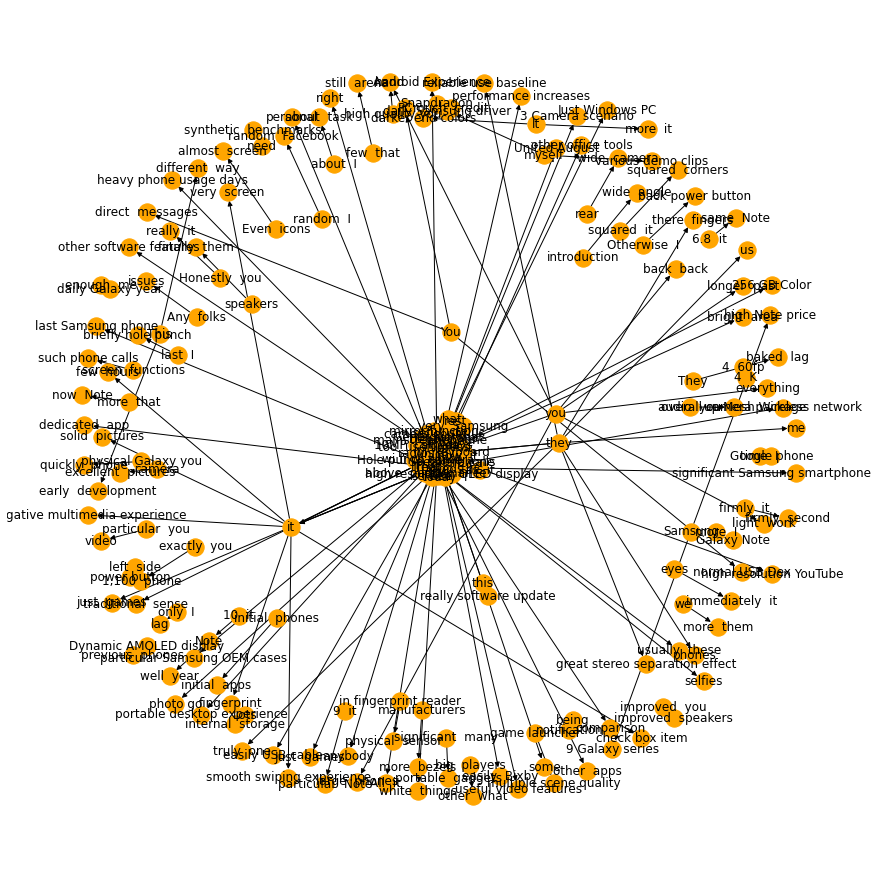

In [18]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='orange', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

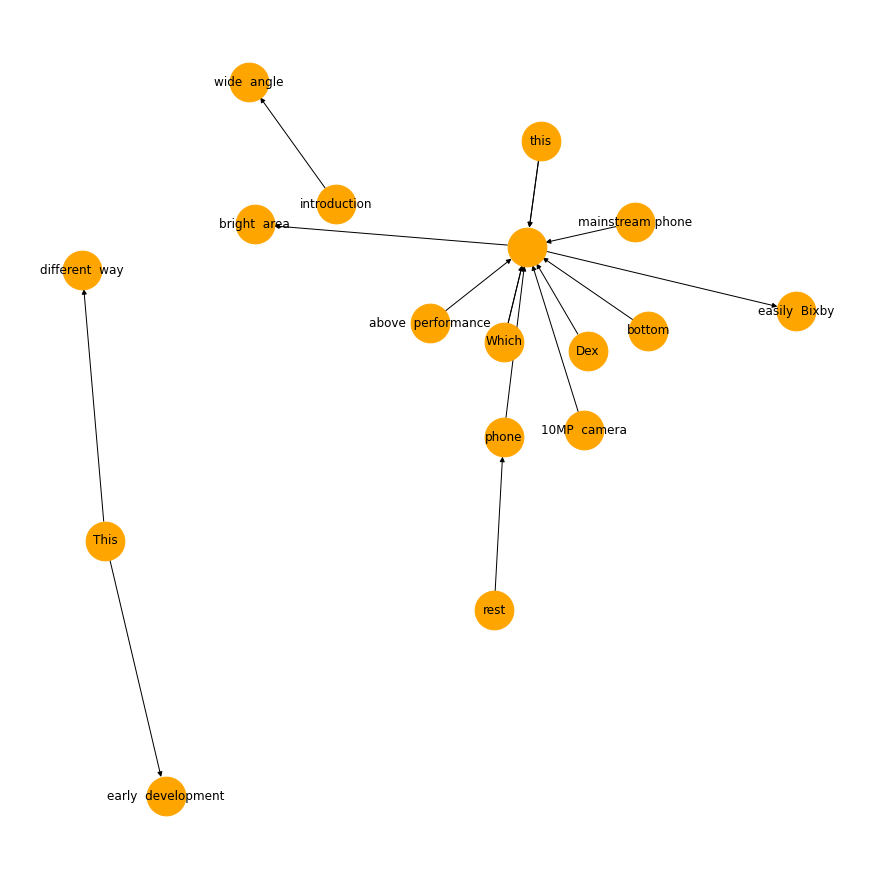

In [19]:
#build a partial knowledge graph with the most common relationship

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='orange', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<h2> Part 5: Limitations and Future Considerations </h2> 

<h4> When I was inspecting sentence segmentation, it became apparent that there were a few outliers, i.e. some sentences included multiple subjects and predicates. Given that all sentences have non-homogenous structure, I decided to manually split such sentences which took me roughly 10 minutes.</h4>

<h4> Furthermore, when I was inspecting the list of the concept pairs obtained, I noticed that some pairs included empty space, i.e. '', as a subject or an object. This definitely has influenced the final graph, however, I would need assistance with figuring out howto fix this issue. </h4>

<h4> Hence, for the future developments and improvements, it is advisable to perform further data inspection and fix the issue with blank spaces. </h4>